In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


import hydra
from typing import Optional
from collections.abc import Callable
from omegaconf import OmegaConf, DictConfig
from data_module.lightning_data_module import DataModule
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

1. bevdepth data load 
2. our data load 
3. get item 비교

0. bev depth 로직 파악 
1. BEVdepth's data 이용
2. model cvt로 이전 작업 


In [2]:
def setup(cfg):

    cfg.loader.batch_size = 1

    if 'split' not in cfg:
        cfg.split = 'val'

    if 'shuffle' not in cfg:
        cfg.shuffle = False
        
def setup_config(cfg: DictConfig, override: Optional[Callable] = None):

    OmegaConf.set_struct(cfg, False)
    OmegaConf.resolve(cfg)
    OmegaConf.set_struct(cfg, True)


def merge_rgbs(imgs):

    fl = np.transpose(imgs[0], (1,2,0))
    ff = np.transpose(imgs[1], (1,2,0))
    fr = np.transpose(imgs[2], (1,2,0))

    front = np.hstack([fl, ff, fr])

    bl = np.transpose(imgs[5], (1,2,0))
    bf = np.transpose(imgs[4], (1,2,0))
    br = np.transpose(imgs[3], (1,2,0))

    back = np.hstack([bl, bf, br])

    whole = np.vstack([front, back])

    return whole

def vis_gt(bev):
    bev = np.transpose(bev, (1, 2, 0))
    area = bev[:,:,0] + bev[:,:,1]
    divider = bev[:,:,2] + bev[:,:,3]
    vehicle = bev[:,:,4] + bev[:,:,5] + bev[:,:,6] + bev[:,:,7]

    h, w = area.shape
    vis = np.full((h, w, 3), 255, dtype='uint8')

    
    for i, bibev in enumerate([area, divider, vehicle]):
    # for i, bibev in enumerate([area, vehicle]):
        vis[bibev!=0,:] = mapping[i]
    
    vis[95:105, 98:102, :] = (255, 0, 0)

    return vis

In [3]:
# *  config setup  * #
CONFIG_PATH = '/usr/src/CV_For_Autonomous_Driving/config'

with initialize_config_dir(config_dir=CONFIG_PATH):
    cfg = compose(config_name='default_config_debug.yaml')

    
setup_config(cfg, setup)

# dataset list 만드는 test
DM = DataModule('nuscenes_generated', cfg.data, cfg.loader)
split = 'train'
data_cfg_our = DM.data_cfg
datasets = DM.get_data(split=split,
                            **data_cfg_our)
# val_dataloader = DM.val_dataloader()
# data = next(iter(val_dataloader))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  after removing the cwd from sys.path.


In [4]:
from model_module.bev_depth_lss_r50_256x704_128x128_24e_2key import BEVDepthLightningModel
from data_module.nusc_det_dataset import NuscDetDataset
import os


H = 900
W = 1600
final_dim = (256, 704)
img_conf = dict(img_mean=[123.675, 116.28, 103.53],
                img_std=[58.395, 57.12, 57.375],
                to_rgb=True)

backbone_conf = {
    'x_bound': [-51.2, 51.2, 0.8],
    'y_bound': [-51.2, 51.2, 0.8],
    'z_bound': [-5, 3, 8],
    'd_bound': [2.0, 58.0, 0.5],
    'final_dim':
    final_dim,
    'output_channels':
    80,
    'downsample_factor':
    16,
    'img_backbone_conf':
    dict(
        type='ResNet',
        depth=50,
        frozen_stages=0,
        out_indices=[0, 1, 2, 3],
        norm_eval=False,
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50'),
    ),
    'img_neck_conf':
    dict(
        type='SECONDFPN',
        in_channels=[256, 512, 1024, 2048],
        upsample_strides=[0.25, 0.5, 1, 2],
        out_channels=[128, 128, 128, 128],
    ),
    'depth_net_conf':
    dict(in_channels=512, mid_channels=512)
}
ida_aug_conf = {
    'resize_lim': (0.386, 0.55),
    'final_dim':
    final_dim,
    'rot_lim': (-5.4, 5.4),
    'H':
    H,
    'W':
    W,
    'rand_flip':
    True,
    'bot_pct_lim': (0.0, 0.0),
    'cams': [
        'CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT',
        'CAM_BACK', 'CAM_BACK_RIGHT'
    ],
    'Ncams':
    6,
}

bda_aug_conf = {
    'rot_lim': (-22.5, 22.5),
    'scale_lim': (0.95, 1.05),
    'flip_dx_ratio': 0.5,
    'flip_dy_ratio': 0.5
}

bev_backbone = dict(
    type='ResNet',
    in_channels=80,
    depth=18,
    num_stages=3,
    strides=(1, 2, 2),
    dilations=(1, 1, 1),
    out_indices=[0, 1, 2],
    norm_eval=False,
    base_channels=160,
)

bev_neck = dict(type='SECONDFPN',
                in_channels=[80, 160, 320, 640],
                upsample_strides=[1, 2, 4, 8],
                out_channels=[64, 64, 64, 64])

CLASSES = [
    'car',
    'truck',
    'construction_vehicle',
    'bus',
    'trailer',
    'barrier',
    'motorcycle',
    'bicycle',
    'pedestrian',
    'traffic_cone',
]

TASKS = [
    dict(num_class=1, class_names=['car']),
    dict(num_class=2, class_names=['truck', 'construction_vehicle']),
    dict(num_class=2, class_names=['bus', 'trailer']),
    dict(num_class=1, class_names=['barrier']),
    dict(num_class=2, class_names=['motorcycle', 'bicycle']),
    dict(num_class=2, class_names=['pedestrian', 'traffic_cone']),
]

common_heads = dict(reg=(2, 2),
                    height=(1, 2),
                    dim=(3, 2),
                    rot=(2, 2),
                    vel=(2, 2))

bbox_coder = dict(
    type='CenterPointBBoxCoder',
    post_center_range=[-61.2, -61.2, -10.0, 61.2, 61.2, 10.0],
    max_num=500,
    score_threshold=0.1,
    out_size_factor=4,
    voxel_size=[0.2, 0.2, 8],
    pc_range=[-51.2, -51.2, -5, 51.2, 51.2, 3],
    code_size=9,
)

train_cfg = dict(
    point_cloud_range=[-51.2, -51.2, -5, 51.2, 51.2, 3],
    grid_size=[512, 512, 1],
    voxel_size=[0.2, 0.2, 8],
    out_size_factor=4,
    dense_reg=1,
    gaussian_overlap=0.1,
    max_objs=500,
    min_radius=2,
    code_weights=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5],
)

test_cfg = dict(
    post_center_limit_range=[-61.2, -61.2, -10.0, 61.2, 61.2, 10.0],
    max_per_img=500,
    max_pool_nms=False,
    min_radius=[4, 12, 10, 1, 0.85, 0.175],
    score_threshold=0.1,
    out_size_factor=4,
    voxel_size=[0.2, 0.2, 8],
    nms_type='circle',
    pre_max_size=1000,
    post_max_size=83,
    nms_thr=0.2,
)

head_conf = {
    'bev_backbone_conf': bev_backbone,
    'bev_neck_conf': bev_neck,
    'tasks': TASKS,
    'common_heads': common_heads,
    'bbox_coder': bbox_coder,
    'train_cfg': train_cfg,
    'test_cfg': test_cfg,
    'in_channels': 256,  # Equal to bev_neck output_channels.
    'loss_cls': dict(type='GaussianFocalLoss', reduction='mean'),
    'loss_bbox': dict(type='L1Loss', reduction='mean', loss_weight=0.25),
    'gaussian_overlap': 0.1,
    'min_radius': 2,
}

val_dataset = NuscDetDataset(ida_aug_conf= ida_aug_conf,
                                     bda_aug_conf= bda_aug_conf,
                                     classes= CLASSES,
                                     data_root='/usr/src/nuscenes',
                                     info_paths=os.path.join('/usr/src/nuscenes', 'nuscenes_infos_train.pkl'),
                                     is_train=True,
                                     img_conf= img_conf,
                                     num_sweeps=1,
                                     sweep_idxes=list(),
                                     key_idxes= list(),
                                     return_depth=True,
                                     use_fusion= False)
                                 
# data_bd = next(iter(model_module.val_dataloader()))

In [5]:
data = datasets[0].__getitem__(10)   # scene0 (by concate), 1 scene당 39~41, train=700, val=150
data_bd = val_dataset.__getitem__(10)  
# print(len(val_dataset), len(datasets)) #! 6019 150

        'bev': torch.Size([b, 12, 200, 200])
        'view': torch.Size([b, 3, 3])
        'center': torch.Size([b, 1, 200, 200])
        'visibility': torch.Size([b, 200, 200])
        'depths': torch.Size([b, 6, 900, 1600])
        'cam_idx': torch.Size([b, 6])
        'image': torch.Size([b, 6, 3, 900, 1600])
        'intrinsics': torch.Size([b, 6, 3, 3])
        'extrinsics': torch.Size([b, 6, 4, 4])
        'sensor2sensor_mats': torch.Size([b, 6, 4, 4])
        'sensor2ego_mats': torch.Size([b, 6, 4, 4])
        'ida_mats': torch.Size([b, 6, 4, 4])

        'img_metas': list
            'token': str
            'ego2global_translation': torch.Size([3])
            'ego2global_rotation': torch.Size([4])

        'gt_boxes': [[batch_1_gts], [batch_2_gts], ..., [batch_b_gts]]
            batch_1_gts: torch.Size([n, 9])
        'gt_labels': [[batch_1_gts], [batch_2_gts], ..., [batch_b_gts]]
            batch_1_gts: torch.Size([n])

In [6]:
print(data['image'][0].shape)
imgs = data['image'][0].numpy().transpose(1,2,0)
cropped_imgs = data['images_before_crop'][0].numpy().transpose(1,2,0)



torch.Size([3, 256, 704])


In [7]:
print(imgs.shape)

(256, 704, 3)


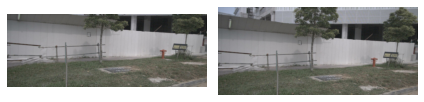

In [8]:
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(imgs)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cropped_imgs)

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 704])
(256, 704, 3)


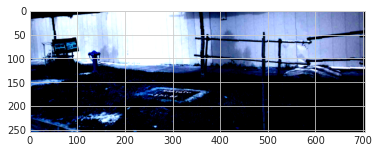

In [9]:
print(data_bd[0][0][0].shape)
imgs = data_bd[0][0][0].numpy().transpose(1,2,0)


print(imgs.shape)

plt.imshow(imgs)

plt.show()

### Visualization: depth ground truth

[ 2.86406159  2.87179971  2.90677166 ... 62.76620483 62.83993912
 63.05830383]


(-0.5, 739.225, 268.825, -0.5)

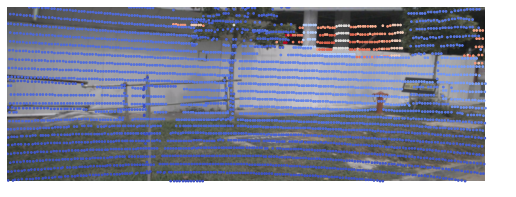

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))

# fig.canvas.set_window_title(sample_token)
img = np.transpose(data['image'][0].numpy(), (1,2,0))
depth = data['depths'][0].numpy()

h, w = depth.shape

x = np.linspace(0, w, w)
y = np.linspace(0, h, h)
xs, ys = np.meshgrid(x, y)

xs_flat = xs.flatten()
ys_flat = ys.flatten()
depth_flat = depth.flatten()

mask = depth_flat > 1e-5
xs_filter = xs_flat[mask]
ys_filter = ys_flat[mask]
depth_filter = depth_flat[mask]

print(np.unique(depth_filter))

ax.imshow(img)
ax.scatter(xs_filter, ys_filter, c=depth_filter, s=3, cmap='coolwarm') 


ax.axis('off')

In [11]:
data_bd[-1][0][0].numpy().shape #! depth: (256, 704)

# data_bd[0][0][0].numpy().shape  #! sweep_imgs: (3, 256, 704)

(256, 704)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.8640616  2.8717997  2.9067717 ... 55.390205  55.638893  55.96102  ]


(-0.5, 739.225, 268.825, -0.5)

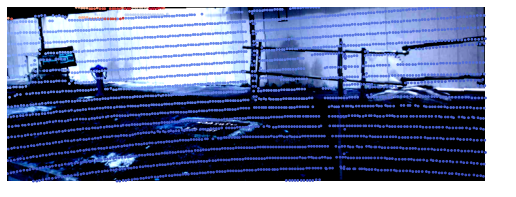

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))

# fig.canvas.set_window_title(sample_token)
img_bd = np.transpose(data_bd[0][0][0].numpy(), (1,2,0))
depth_bd = data_bd[-1][0][0].numpy()

h, w = depth.shape

x = np.linspace(0, w, w)
y = np.linspace(0, h, h)
xs, ys = np.meshgrid(x, y)

xs_flat = xs.flatten()
ys_flat = ys.flatten()
depth_flat = depth_bd.flatten()

mask = depth_flat > 1e-5
xs_filter = xs_flat[mask]
ys_filter = ys_flat[mask]
depth_filter = depth_flat[mask]

print(np.unique(depth_filter))

ax.imshow(img_bd)
ax.scatter(xs_filter, ys_filter, c=depth_filter, s=3, cmap='coolwarm') 


ax.axis('off')

### Visualization: 3d bbox ground truth & BEV segmentation map

In [13]:
# 3d bbox 
mapping = {0: (255, 153, 51),
            1: (0, 128, 255),
            2: (0, 0, 255)}

bev_map = np.full((200, 200, 3), 255)

gt_bbox = data['gt_boxes']
gt_cls = data['gt_labels'].numpy()

# merge images

merged_imgs = merge_rgbs(data['image'].numpy())
# bev: torch.Size([200, 200, 12])
bev = vis_gt(data['bev'].numpy())

# np.unique(data['bev'][0].numpy())


In [14]:
data_bd[-3].shape
# data_bd[-2].shape

torch.Size([9, 9])

In [15]:
# 3d bbox 
mapping = {0: (255, 153, 51),
            1: (0, 128, 255),
            2: (0, 0, 255)}

bev_map = np.full((200, 200, 3), 255)

gt_bbox = data_bd[-3]
gt_cls = data_bd[-2].numpy()

# merge images

merged_imgs = merge_rgbs(data_bd[0][0].numpy())
# bev: torch.Size([200, 200, 12])
bev = vis_gt(data['bev'].numpy())

# np.unique(data['bev'][0].numpy())


In [16]:
data['image'].shape

torch.Size([6, 3, 256, 704])

In [17]:
cls_mapping = {}
for i in range(10):
    cls_mapping[i] = np.random.rand((3))*255

In [18]:
from data_module.dataset.utils import *
#(0,0), top left
bev_cfg = {'h': 200, 'w': 200, 
                    'h_meters': 100.0, 'w_meters': 100.0, 'offset': 0.0}
meter2pix = get_bev_meter2pix_matrix(bev_cfg)

In [19]:
def rotate_points_along_z(points, angle):
    """
    Args:
        points: (B, N, 3 + C)
        angle: (B), angle along z-axis, angle increases x ==> y
    Returns:
    """
    cosa = np.cos(angle)
    sina = np.sin(angle)
    zeros = np.zeros(points.shape[0])
    ones = np.ones(points.shape[0])
    rot_matrix = np.stack(
        (cosa, sina, zeros, -sina, cosa, zeros, zeros, zeros, ones),
        axis=1).reshape(-1, 3, 3)
    points_rot = np.matmul(points[:, :, 0:3], rot_matrix)
    points_rot = np.concatenate((points_rot, points[:, :, 3:]), axis=-1)
    return points_rot


def get_bev_lines(corners):
    return [[[corners[i, 0], corners[(i + 1) % 4, 0]],
             [corners[i, 1], corners[(i + 1) % 4, 1]]] for i in range(4)]

def get_corners(boxes3d):
    """
        7 -------- 4
       /|         /|
      6 -------- 5 .
      | |        | |
      . 3 -------- 0
      |/         |/
      2 -------- 1
    Args:
        boxes3d:  (N, 7) [x, y, z, dx, dy, dz, heading],
            (x, y, z) is the box center
    Returns:
    """
    template = (np.array((
        [1, 1, -1],
        [1, -1, -1],
        [-1, -1, -1],
        [-1, 1, -1],
        [1, 1, 1],
        [1, -1, 1],
        [-1, -1, 1],
        [-1, 1, 1],
    )) / 2)

    corners3d = np.tile(boxes3d[:, None, 3:6],
                        [1, 8, 1]) * template[None, :, :]
    corners3d = rotate_points_along_z(corners3d.reshape(-1, 8, 3),
                                      boxes3d[:, 6]).reshape(-1, 8, 3)
    corners3d += boxes3d[:, None, 0:3]

    return corners3d

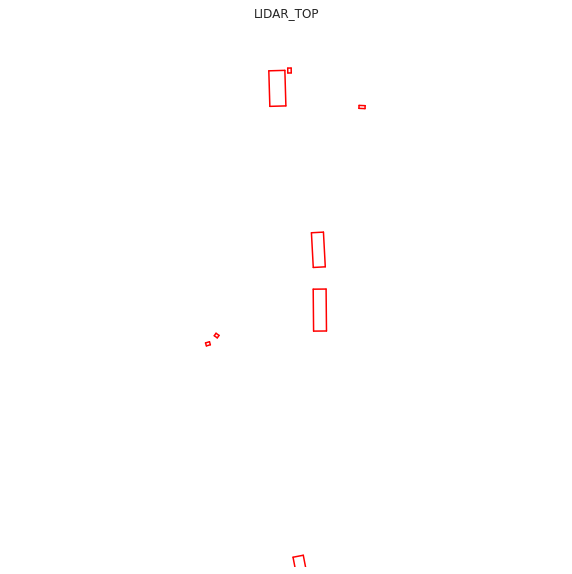

In [20]:
import matplotlib.patches as patches

bev_map = np.full((200, 200), 255)


gt_corners = []
for i in range(len(gt_bbox)):
    box = gt_bbox[i].numpy()
    if np.linalg.norm(box[:2]) <= 60:
        corners = get_corners(box[None])[0]
        gt_corners.append(corners)


plt.figure(figsize=(10, 10))

# Set BEV attributes
plt.title('LIDAR_TOP')
plt.axis('equal')
plt.axis('off')
plt.xlim(-50, 50)
plt.ylim(-50, 50)

for corners in gt_corners:
    lines = get_bev_lines(corners)
    for line in lines:
        plt.plot([-x for x in line[1]],
                    line[0],
                    c='r',
                    label='ground truth')



(-0.5, 199.5, 199.5, -0.5)

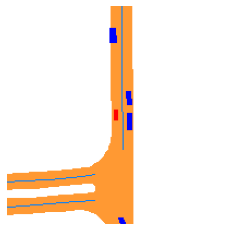

In [21]:
np.unique(data['bev'].numpy())
plt.imshow(bev)
plt.axis('off')

In [22]:
merged_imgs.shape

(512, 2112, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2111.5, 511.5, -0.5)

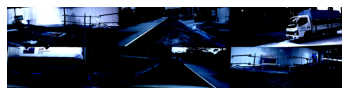

In [23]:
plt.imshow(merged_imgs)
plt.axis('off')